## Model Training

### Importing necessary libraries

In [ ]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Importing the Data

In [2]:
df = pd.read_csv('data/processed_data.csv')

### Show Top 5 records

In [3]:
df.head(5)

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### Verify column data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobType              1000000 non-null  object
 1   degree               1000000 non-null  object
 2   major                1000000 non-null  object
 3   industry             1000000 non-null  object
 4   yearsExperience      1000000 non-null  int64 
 5   milesFromMetropolis  1000000 non-null  int64 
 6   salary               1000000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 53.4+ MB


### Preparing X and y variables

In [5]:
X = df.drop('salary', axis=1)
y = df['salary']

In [6]:
X.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,CFO,MASTERS,MATH,HEALTH,10,83
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [7]:
# Creaate a Column Transformer with 2 types of transformers
num_features = X.select_dtypes(exclude = ['object']).columns
cat_features = X.select_dtypes(include = ['object']).columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [8]:
X = preprocessor.fit_transform(X)

In [9]:
X.shape

(1000000, 31)

In [10]:
# Prepare the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800000, 31), (200000, 31), (800000,), (200000,))

In [11]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, mse, rmse, r2

#### Note:- For Training purpose, we are going to use only 10,000 records since the dataset is very large and it will take a long time to train the model

In [12]:
models = {
    "Linear Regression" : LinearRegression(),
    "KNeighbors" : KNeighborsRegressor(),
    "RandomForest" : RandomForestRegressor(),
    "AdaBoost" : AdaBoostRegressor(),
    "GradientBoosting" : GradientBoostingRegressor(),
    "XGBoost" : XGBRegressor(),
    "SVR" : SVR(),
    "DecisionTree" : DecisionTreeRegressor()
}

# Create a DataFrame to store the results
train_results = pd.DataFrame(columns=['Model','MAE', 'MSE', 'RMSE', 'R2'])
test_results = pd.DataFrame(columns=['Model','MAE', 'MSE', 'RMSE', 'R2'])

subset_X_train = X_train[:10000]
subset_y_train = y_train[:10000]

for model_name, model in models.items():

    model.fit(subset_X_train, subset_y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_mae, train_mse, train_rmse, train_r2 = evaluate_model(y_train, train_pred)
    test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, test_pred)

    train_results.loc[len(train_results)] = [model_name, train_mae, train_mse, train_rmse, train_r2]
    test_results.loc[len(test_results)] = [model_name, test_mae, test_mse, test_rmse, test_r2]

### Analyze the Train and Test results

In [13]:
train_results = train_results.sort_values(by='R2', ascending=False)
train_results

,Model,MAE,MSE,RMSE,R2
4,GradientBoosting,15.711896,378.591917,19.457439,0.747265
0,Linear Regression,15.872854,385.783795,19.641380,0.742463
5,XGBoost,16.317398,418.603668,20.459806,0.720554
6,SVR,16.304444,419.542759,20.482743,0.719927
2,RandomForest,16.491293,428.627329,20.703317,0.713863
1,KNeighbors,17.313381,478.804366,21.881599,0.680366
3,AdaBoost,20.905996,635.336632,25.205885,0.575870
7,DecisionTree,22.179601,822.335673,28.676396,0.451036


In [14]:
test_results = test_results.sort_values('R2', ascending=False)
test_results

,Model,MAE,MSE,RMSE,R2
4,GradientBoosting,15.714417,378.295213,19.449813,0.748385
0,Linear Regression,15.856204,384.918043,19.619328,0.743980
6,SVR,16.305777,419.565427,20.483296,0.720935
5,XGBoost,16.378218,420.756927,20.512360,0.720143
2,RandomForest,16.592341,431.947760,20.783353,0.712699
1,KNeighbors,17.349455,480.651448,21.923764,0.680305
3,AdaBoost,20.874369,633.930331,25.177973,0.578355
7,DecisionTree,22.375727,825.756699,28.735983,0.450766


### Hyperparameter Tuning

In [15]:
param_grid = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "RandomForest": {
        "n_estimators": [100, 200, 500],
        # "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10],
        # "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0]
    },
    "SVR": {
        "kernel": ["linear", "rbf", "poly"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"]
    },
    "DecisionTree": {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

#### GridSearchCV for finding best hyperparameters

In [17]:
best_models = {}

for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}...")
    grid = GridSearchCV(model, param_grid[model_name], cv=3, n_jobs=1, verbose=2)
    grid.fit(subset_X_train, subset_y_train)
    
    # Store the best model
    best_models[model_name] = grid.best_estimator_
    print(f"Best params for {model_name}: {grid.best_params_}")

Running GridSearchCV for Linear Regression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
Running GridSearchCV for KNeighbors...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; tota

In [24]:
best_models

{'Linear Regression': LinearRegression(fit_intercept=False),
 'KNeighbors': KNeighborsRegressor(metric='euclidean', n_neighbors=10, weights='distance'),
 'RandomForest': RandomForestRegressor(min_samples_split=10, n_estimators=500),
 'AdaBoost': AdaBoostRegressor(learning_rate=1, n_estimators=100),
 'GradientBoosting': GradientBoostingRegressor(n_estimators=200),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
    

### Retraining the Models with the hyperparameters

In [38]:
# Randomly sample 10,000 records from X_train for training
subset_X_train, _, subset_y_train, _ = train_test_split(X_train, y_train, train_size=10000, random_state=42)

# Define models with hyperparameters
models_new = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'KNeighbors': KNeighborsRegressor(metric='euclidean', n_neighbors=10, weights='distance'),
    'RandomForest': RandomForestRegressor(min_samples_split=10, n_estimators=500, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(learning_rate=1, n_estimators=100),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200),
    'XGBoost': XGBRegressor(max_depth=3, n_estimators=200, learning_rate=0.1, 
                            colsample_bytree=0.8, subsample=0.7, n_jobs=-1),
    'SVR': SVR(C=100, gamma='auto'),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10)
}

# Initialize result DataFrames
train_results_new = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
test_results_new = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

# Train models and evaluate performance
for model_name, model in models_new.items():
    print(f"Training {model_name}...")
    model.fit(subset_X_train, subset_y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Evaluate model
    train_mae, train_mse, train_rmse, train_r2 = evaluate_model(y_train, train_pred)
    test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, test_pred)

    # Store results
    train_results_new = pd.concat([train_results_new, pd.DataFrame(
        [[model_name, train_mae, train_mse, train_rmse, train_r2]], 
        columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2']
    )], ignore_index=True)

    test_results_new = pd.concat([test_results_new, pd.DataFrame(
        [[model_name, test_mae, test_mse, test_rmse, test_r2]], 
        columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2']
    )], ignore_index=True)

Training Linear Regression...
Training KNeighbors...
Training RandomForest...
Training AdaBoost...
Training GradientBoosting...
Training XGBoost...
Training SVR...
Training DecisionTree...


In [48]:
print("\nTrain Results:")
train_results_new = train_results_new.sort_values(by='R2', ascending=False)
print(train_results_new)


Train Results:
               Model        MAE         MSE       RMSE        R2
5            XGBoost  15.557354  369.690552  19.227339  0.753207
4   GradientBoosting  15.598351  372.301123  19.295106  0.751464
6                SVR  15.611140  374.639706  19.355612  0.749903
0  Linear Regression  15.867463  385.955880  19.645760  0.742349
2       RandomForest  16.263097  413.893431  20.344371  0.723698
1         KNeighbors  16.611298  441.681335  21.016216  0.705148
7       DecisionTree  18.252934  535.681986  23.144805  0.642396
3           AdaBoost  20.790103  620.422910  24.908290  0.585826


In [49]:
print("\nTest Results:")
test_results_new = test_results_new.sort_values(by='R2', ascending=False)
print(test_results_new)


Test Results:
               Model        MAE         MSE       RMSE        R2
5            XGBoost  15.546963  368.938721  19.207778  0.754608
4   GradientBoosting  15.598941  372.074501  19.289233  0.752523
6                SVR  15.597295  374.103943  19.341767  0.751173
0  Linear Regression  15.843726  384.804723  19.616440  0.744055
2       RandomForest  16.325818  416.563254  20.409881  0.722932
1         KNeighbors  16.805790  446.864016  21.139158  0.702778
7       DecisionTree  18.292664  537.898443  23.192638  0.642228
3           AdaBoost  20.749798  617.802507  24.855633  0.589082


## Best Model

After hyperparameter tuning, XGBRegressor emerged as the best-performing model, achieving the highest R² score, indicating its superior predictive accuracy.

Since there are 1,00,000 records, we can train XGBRegressor on GPU for faster training)

In [51]:
model = XGBRegressor(max_depth=3, n_estimators=200, learning_rate=0.1, 
                            colsample_bytree=0.8, subsample=0.7, n_jobs=-1,  tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print("Accuracy of the model: %.2f" %(score*100), "%")

Accuracy of the model: 76.12 %


### Further Hyperparameter Tuning

With the model achieving an accuracy of 76.12%, we will proceed to refine its performance further by hyperparameter tuning. This process will help us evaluate whether the model's efficiency can be improved.

In [62]:
print(type(y_train))

<class 'pandas.core.series.Series'>


In [70]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],  # Controls complexity
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size
    'colsample_bytree': [0.7, 0.8, 0.9],  # Feature sampling
    'subsample': [0.6, 0.7, 0.8],  # Data sampling
    'gamma': [0, 1, 5],  # Regularization for tree split
    
}

# Initialize model with GPU
xgb = XGBRegressor(n_jobs=-1)

# GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    verbose=2, 
    n_jobs=1
)

# Train the model on a subset (if needed, due to computational cost)
grid_search.fit(X_train[:20000], y_train[:20000])  # Use first 20,000 rows for efficiency

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

# Best Model
best_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, m

In [71]:
model = XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.1, gamma = 0,
                            colsample_bytree=0.8, subsample=0.7, n_jobs=-1,  tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print("Accuracy of the model: %.2f" %(score*100), "%")

Accuracy of the model: 76.30 %


### Results of Further Hyperparameter Tuning

Despite additional hyperparameter tuning, the accuracy of the model showed only a marginal improvement, increasing from **76.12%** to **76.30%**. This suggests that the model may have reached its performance limit with the current dataset and feature set. Further strategies, such as feature engineering, using a different model architecture, or obtaining more diverse data, might be needed to achieve substantial performance gains.

### Plot Scatter Plot for y_pred and y_test

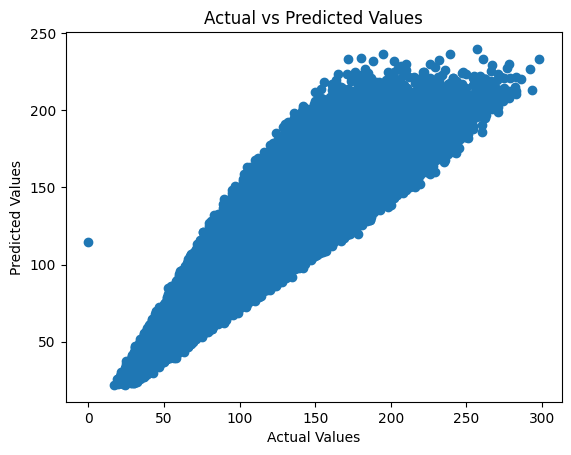

In [72]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### Plot regplot for y_pred and y_test

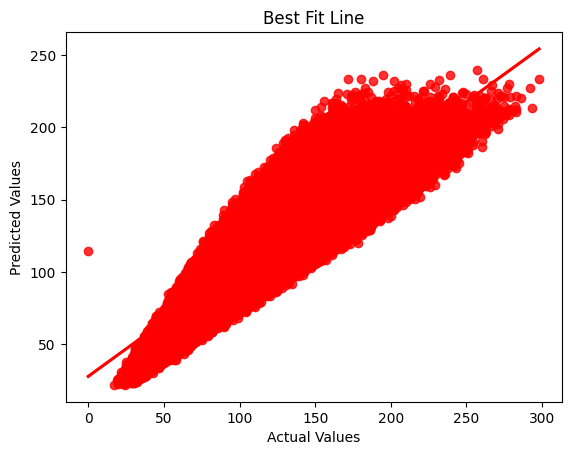

In [73]:
sns.regplot(x = y_test, y = y_pred, ci = None, color = 'red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Best Fit Line")
plt.show()

### Difference between Actual and Predicted Values

In [74]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': y_test - y_pred})
pred_df.head(10)

,Actual,Predicted,Difference
987231,174,142.233383,31.766617
79954,58,69.329536,-11.329536
567130,168,183.953003,-15.953003
500891,85,115.491241,-30.491241
55399,145,123.818962,21.181038
135049,135,126.245110,8.754890
733378,153,118.863213,34.136787
732057,82,86.249725,-4.249725
51333,120,117.709335,2.290665
731479,147,131.115143,15.884857


In [76]:
import os
import pickle

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the preprocessor
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('models/model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Preprocessor and model saved successfully!")


Preprocessor and model saved successfully!
